# Waste Classification using Trashnet Dataset + scrap from google + own dataset

Data set : https://github.com/garythung/trashnet


---







### Import module

In [98]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

from numpy import random
from tensorflow import keras

In [99]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Define path dataset

In [72]:
base_path = "/content/drive/MyDrive/Bangkit/Capstone/dataset"
dataset_train = os.path.join(base_path, 'train')
dataset_test = os.path.join(base_path, 'test')
print(os.listdir(dataset_train))
print(os.listdir(dataset_test))

['metal', 'cardboard', 'glass', 'paper', 'plastic']
['metal', 'cardboard', 'glass', 'paper', 'plastic']


## Delete unnecessary hidden files

In [73]:
import glob
import shutil

def delete(path):
    if os.path.isfile(path) or os.path.islink(path):
        os.remove(path)
    elif os.path.isdir(path):
        shutil.rmtree(path)
    print('deleted: ' + path)

n = 0
for root, subdir, file in os.walk(dataset_train):
    pattern = os.path.join(root, '.*')
    for path in (glob.glob(pattern)):
        n += 1
        # print(path)
        delete(path)
print(f'{n} hidden file or folder found')

0 hidden file or folder found


## Check invalid image

In [74]:
from tensorflow.errors import InvalidArgumentError

def check_invalid_image(dataset_dir):
    invalid_images = list()
    for root, subdirs, files in os.walk(dataset_dir):
        for file in files:
            image_path = os.path.join(root, file)
            image = tf.io.read_file(image_path)
            try:    
                image = tf.io.decode_image(image,)
            except InvalidArgumentError:
                invalid_images.append(image_path)
    return (invalid_images, len(invalid_images))

data_train = check_invalid_image(dataset_train)
print(data_train)
data_test = check_invalid_image(dataset_test)
print(data_test)

# delete invalid image
for path_file in data_train[0]:
    os.remove(path_file)

for path_file in data_test[0]:
    os.remove(path_file)

([], 0)
([], 0)


## Check image detail

In [75]:
class_image = os.listdir(dataset_train)
class_image

['metal', 'cardboard', 'glass', 'paper', 'plastic']

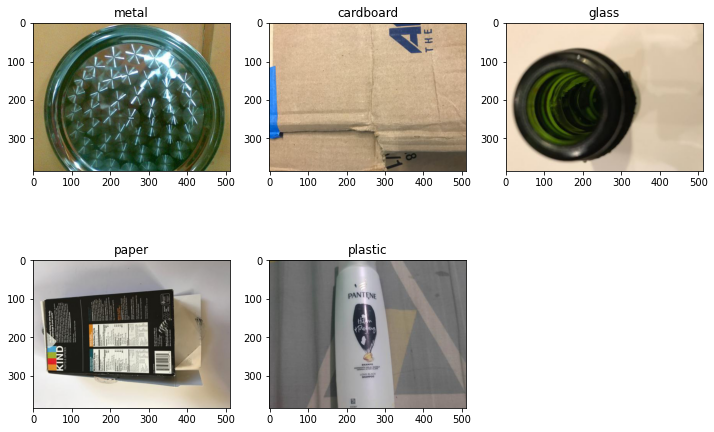

In [76]:
def get_random_data_perclass():
    random_data_perclass = []

    for root, _, files in os.walk(dataset_train):
        # skip check folder in data_resized
        if len(files) == 0: 
            continue
        random_index = random.randint(0, len(files) - 1)
        rand_data_path = os.path.join(root,  files[random_index])
        random_data_perclass.append(rand_data_path)
    return random_data_perclass

# subplot dimension
nrows = 2
ncols = 3

# Index for iterating over images
pic_index = 0
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

random_data = get_random_data_perclass()
for i, img_path in enumerate(random_data):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('On')
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(class_image[i])

In [77]:
def get_all_image_path():
    data = []
    for root, dirs, files in os.walk(dataset_train):
        # skip check folder in data_resized
        if len(files) == 0:
            continue
        for file in files:
            img_path = os.path.join(root, file)
            data.append(img_path)
    return data

### image description

In [78]:
# image description
n_data = len(get_all_image_path())
print("Number of image data: " + str(n_data))

image = mpimg.imread(random_data[random.randint(0, 5)])
print(f"Image height: {image.shape[0]}")
print(f"Image width: {image.shape[1]}")
print(f"Image channel: {image.ndim}")

Number of image data: 2500
Image height: 384
Image width: 512
Image channel: 3


### number of image per class in train dataset

In [79]:
for i, (_, __, files) in enumerate(os.walk(dataset_train)):
    if not files:
        continue
    print(f'{len(files)} images of {class_image[i - 1]}')

500 images of metal
500 images of cardboard
500 images of glass
500 images of paper
500 images of plastic


## Load image

### define some image parameter

In [80]:
BATCH_SIZE = 120
IMG_HEIGHT = 256
IMG_WIDTH = 256

### load image as tf.dataset

In [81]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_train,
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=123,
    label_mode = 'categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_train,
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=123,
    label_mode = 'categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_test,
    label_mode = 'categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)


Found 2500 files belonging to 5 classes.
Using 2000 files for training.
Found 2500 files belonging to 5 classes.
Using 500 files for validation.
Found 862 files belonging to 5 classes.


In [82]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic']


### Show sample image from tf.dataset

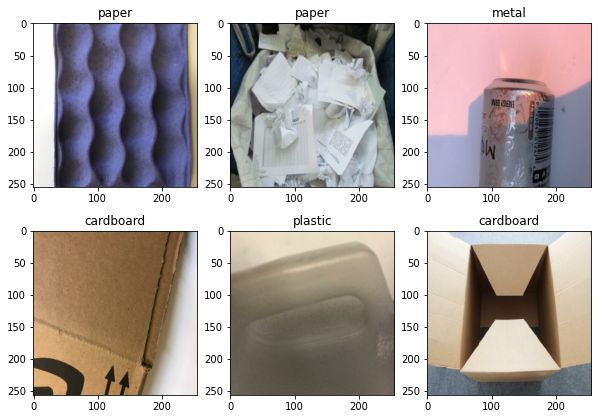

In [83]:
@tf.function
def ds(data):
    return next(iter(data))

image_batch, label_batch = ds(train_ds)
plt.figure(figsize=(10, 7))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    index_classnames = np.argmax(np.array(label))
    plt.title(class_names[index_classnames])
    plt.axis("on")

### Image Augmentaion

In [84]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_HEIGHT, IMG_WIDTH),
    tf.keras.layers.Rescaling(1./255.)
])

data_augmentation = tf.keras.Sequential([ 
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation((-0.3,0.3)),
    tf.keras.layers.RandomZoom((-0.2,0.1)),
    tf.keras.layers.RandomTranslation(0.1,0.1)
])

## Modeling

### Transfer learning

In [86]:
base_model = tf.keras.applications.Xception(
    include_top=False, 
    weights='imagenet', 
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)
base_model.trainable = False

In [87]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    resize_and_rescale,
    data_augmentation,
    base_model,

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

# model.build(input_shape=(256, 256, 3))

### Training

In [88]:
model.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_37 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 sequential_38 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 flatten_17 (Flatten)        (None, 131072)            0         
                                                                 
 dense_51 (Dense)            (None, 128)               16777344  
                                                                 
 dense_52 (Dense)            (None, 64)                8256      
                                                                 
 dense_53 (Dense)            (None, 5)               

In [89]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=(0.001)),
              metrics=['accuracy'])

In [90]:
ACCURACY_THRESHOLD = 0.95
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') > ACCURACY_THRESHOLD):
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True

In [91]:
callbacks = myCallback()
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=40,
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/40
17/17 [==============================] - 40s 1s/step - loss: 3.2218 - accuracy: 0.5115 - val_loss: 1.0075 - val_accuracy: 0.7280
Epoch 2/40
17/17 [==============================] - 19s 984ms/step - loss: 0.8210 - accuracy: 0.7675 - val_loss: 0.6673 - val_accuracy: 0.7620
Epoch 3/40
17/17 [==============================] - 19s 997ms/step - loss: 0.5536 - accuracy: 0.8175 - val_loss: 0.6832 - val_accuracy: 0.7740
Epoch 4/40
17/17 [==============================] - 20s 1s/step - loss: 0.4640 - accuracy: 0.8265 - val_loss: 0.5876 - val_accuracy: 0.8020
Epoch 5/40
17/17 [==============================] - 20s 1s/step - loss: 0.4387 - accuracy: 0.8385 - val_loss: 0.5021 - val_accuracy: 0.8080
Epoch 6/40
17/17 [==============================] - 20s 1s/step - loss: 0.4068 - accuracy: 0.8570 - val_loss: 0.6096 - val_accuracy: 0.8000
Epoch 7/40
17/17 [==============================] - 21s 1s/step - loss: 0.4028 - accuracy: 0.8600 - val_loss: 0.5276 - val_accuracy: 0.8140
Epoch 8/40
17/

### Plotting result training

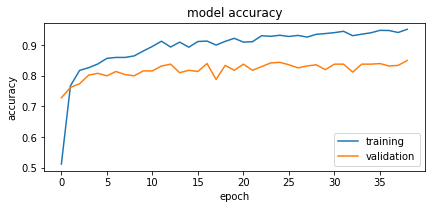

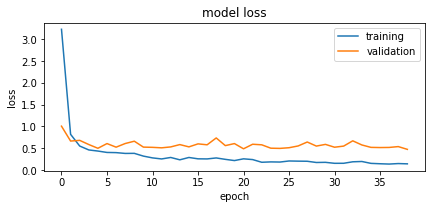

In [92]:
from matplotlib.pyplot import figure
figure(figsize=(15, 6))

plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='lower right')

figure(figsize=(15, 6))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

### Evaluate model

In [93]:
model.evaluate(test_ds)

8/8 [==============================] - 8s 790ms/step - loss: 0.5055 - accuracy: 0.8492


[0.5055115818977356, 0.8491879105567932]


### Save model

In [94]:
import datetime
now = datetime.datetime.now()
time = now.strftime("%Y-%m-%d_%H:%M:%S")
path_h5 = os.path.join('/content/drive/MyDrive/Bangkit/Capstone/', 'modelh5')

In [95]:
model.save( os.path.join(path_h5, f'trashnet_{time}-xception-(256x256)-augmented-preprocessing-plus-newdataset-fix-shape.h5'))

### Try prediction with new data

Saving data.jpeg to data (1).jpeg


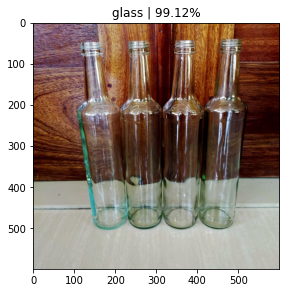

In [120]:
class_names = train_ds.class_names

import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()
i = 0
plt.figure(figsize=(15, 10))
for fn in uploaded.keys():
    img_path = os.path.join('/content', fn)
    img = tf.keras.utils.load_img(
        img_path, target_size=(IMG_HEIGHT, IMG_WIDTH)
    )
    
    img_array = tf.keras.utils.img_to_array(img)    
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)

    sp = plt.subplot(2, 3, i + 1)
    img = mpimg.imread(img_path) 
    plt.imshow(img)
    plt.title(f"{class_names[np.argmax(predictions[0])]} | {100 * np.max(predictions[0]):.2f}%")
    # print(f"{class_names[np.argmax(predictions[0])]} with a {100 * np.max(predictions[0]):.2f} percent confidence.")
    
